In [1]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, matthews_corrcoef
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
import keras_tuner as kt
#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2023-11-19 21:59:54.145638: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 21:59:54.333511: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 21:59:54.333553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 21:59:54.334500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 21:59:54.429265: I tensorflow/core/platform/cpu_feature_g

Using TensorFlow backend


In [2]:
path="animals/animals"
data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      
print(data["labels"])
df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

['Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat'

## Model 1 Data Processing

In [3]:
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath    labels
0  animals/animals/Elephant/Elephant-Train (626)....  Elephant
1    animals/animals/Hippo/Hippo - Train (1313).jpeg     Hippo
2    animals/animals/Beetle/Beetle-Train (1453).jpeg    Beetle
3     animals/animals/Hippo/Hippo - Train (549).jpeg     Hippo
4            animals/animals/Panda/Panda (2791).jpeg     Panda
(14000, 3)
----------Test--------------
                                          imgpath  labels
0        animals/animals/Cow/Cow-Train (906).jpeg     Cow
1  animals/animals/Beetle/Beetle-Train (773).jpeg  Beetle
2   animals/animals/Mouse/Mouse-Train (1190).jpeg   Mouse
3  animals/animals/Beetle/Beetle-Train (707).jpeg  Beetle
4         animals/animals/Dog/Dog-Train (121).jpg     Dog
(6000, 3)


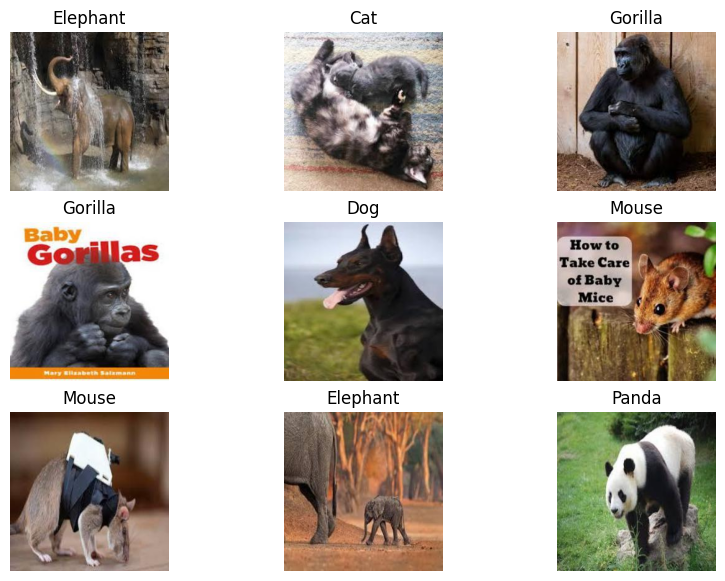

In [4]:
plt.figure(figsize=(10,7))
for i, row in test_df.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [5]:
h=100
w=100
classes = len(df['labels'].unique())
BATCH_SIZE = 16
IMAGE_SIZE = (h, w)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Split the data into 2 categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


## Model 1

In [6]:
def residual_block(x, filters, kernel_size=3, stride=1, use_bottleneck=False):
    shortcut = x
    
    if use_bottleneck:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet(hp):
    input_shape = (h, w, 3)  # Adjust input shape according to your needs
    num_classes = classes
    input_tensor = layers.Input(shape=input_shape)
    hp_kernel_size = hp.Choice('kernel_size',[5,6,7])
    hp_dropout = hp.Choice('dropout',[0.0,0.2,0.3,0.4])
    
    
    x = layers.Conv2D(64, kernel_size=hp_kernel_size, strides=2, padding='same', data_format='channels_last')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(hp_dropout)(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual blocks
    num_blocks_list = [3, 4, 3]
    filters_list = [64, 128, 256]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        filters = filters_list[i]
        stride = 1 if i == 0 else 2

        for j in range(num_blocks):
            x = residual_block(x, filters, stride=stride if j == 0 else 1, use_bottleneck=(j == 0 and i > 0))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='resnet')
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
tuner= kt.GridSearch(ResNet,
                     objective='val_accuracy',
                     project_name='ResNet_tuning')

Reloading Tuner from ./ResNet_tuning/tuner0.json


In [8]:
classes = len(df['labels'].unique())
BATCH_SIZE = 64
IMAGE_SIZE = (h, w)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Split the data into 2 categories.
train_data_generator = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_data_generator = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 14000 validated image filenames belonging to 10 classes.


Found 6000 validated image filenames belonging to 10 classes.


In [9]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
tuner.search(train_data_generator,validation_data=val_data_generator, epochs=1000,validation_split=0.2 , callbacks=[es])

In [10]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'kernel_size': 7, 'dropout': 0.2}


In [69]:
batch_sizes = [32,64,128]
losses = []
accuracies = []
for b in batch_sizes:
    classes = len(df['labels'].unique())
    BATCH_SIZE = b
    IMAGE_SIZE = (h, w)

    generator = ImageDataGenerator(
        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    )

    # Split the data into 2 categories.
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )


    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{batch_sizes}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    losses.append(val_loss)
    accuracies.append(val_acc)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 14000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.
Epoch 1/200


2023-11-19 19:10:17.316760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


435/438 [============================>.] - ETA: 0s - loss: 1.5173 - accuracy: 0.4778

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 14s 22ms/step - loss: 1.5170 - accuracy: 0.4775 - val_loss: 1.8559 - val_accuracy: 0.4057
Epoch 2/200
438/438 [==============================] - 9s 21ms/step - loss: 1.0956 - accuracy: 0.6271 - val_loss: 1.5230 - val_accuracy: 0.4900
Epoch 3/200
438/438 [==============================] - 9s 21ms/step - loss: 0.8793 - accuracy: 0.7042 - val_loss: 1.4434 - val_accuracy: 0.5410
Epoch 4/200
438/438 [==============================] - 9s 21ms/step - loss: 0.6725 - accuracy: 0.7716 - val_loss: 1.4528 - val_accuracy: 0.5512
Epoch 5/200
438/438 [==============================] - 9s 20ms/step - loss: 0.4889 - accuracy: 0.8317 - val_loss: 2.2966 - val_accuracy: 0.4978
Epoch 6/200
438/438 [==============================] - 9s 21ms/step - loss: 0.3345 - accuracy: 0.8893 - val_loss: 2.3895 - val_accuracy: 0.4608
Epoch 7/200
438/438 [==============================] - 9s 21ms/step - loss: 0.2235 - accuracy: 0.9234 - val_loss: 2.7098 - val_accuracy: 0.4758
Epo

2023-11-19 19:13:49.711673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


219/219 [==============================] - 12s 34ms/step - loss: 1.5532 - accuracy: 0.4647 - val_loss: 1.9521 - val_accuracy: 0.3693
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - 7s 33ms/step - loss: 1.0953 - accuracy: 0.6263 - val_loss: 1.5004 - val_accuracy: 0.4992
Epoch 3/200
219/219 [==============================] - 7s 33ms/step - loss: 0.8633 - accuracy: 0.7061 - val_loss: 1.3548 - val_accuracy: 0.5723
Epoch 4/200
219/219 [==============================] - 7s 33ms/step - loss: 0.6641 - accuracy: 0.7786 - val_loss: 1.2934 - val_accuracy: 0.6112
Epoch 5/200
219/219 [==============================] - 7s 31ms/step - loss: 0.4634 - accuracy: 0.8476 - val_loss: 2.1535 - val_accuracy: 0.4737
Epoch 6/200
219/219 [==============================] - 7s 31ms/step - loss: 0.3079 - accuracy: 0.9001 - val_loss: 2.1544 - val_accuracy: 0.5085
Epoch 7/200
219/219 [==============================] - 7s 31ms/step - loss: 0.1937 - accuracy: 0.9390 - val_loss: 1.8326 - val_accuracy: 0.5697
Epoch 8/200
219/219 [==============================] - 7s 31ms/step - loss: 0.1406 - accuracy: 0.9564 - val_loss: 3.0788 - val_accuracy: 0.4493
Epoc

2023-11-19 19:19:24.696265: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 12s 65ms/step - loss: 1.6390 - accuracy: 0.4421 - val_loss: 1.9285 - val_accuracy: 0.3282
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 7s 60ms/step - loss: 1.1434 - accuracy: 0.6073 - val_loss: 1.7243 - val_accuracy: 0.3587
Epoch 3/200
110/110 [==============================] - 7s 59ms/step - loss: 0.9106 - accuracy: 0.6881 - val_loss: 3.0410 - val_accuracy: 0.2782
Epoch 4/200
110/110 [==============================] - 6s 58ms/step - loss: 0.7017 - accuracy: 0.7641 - val_loss: 1.8096 - val_accuracy: 0.4977
Epoch 5/200
110/110 [==============================] - 6s 57ms/step - loss: 0.4947 - accuracy: 0.8350 - val_loss: 1.6962 - val_accuracy: 0.5200
Epoch 6/200
110/110 [==============================] - 6s 56ms/step - loss: 0.3260 - accuracy: 0.8916 - val_loss: 2.5937 - val_accuracy: 0.4393
Epoch 7/200
110/110 [==============================] - 7s 60ms/step - loss: 0.1964 - accuracy: 0.9411 - val_loss: 1.8290 - val_accuracy: 0.5653
Epoch 8/200
110/110 [==============================] - 6s 57ms/step - loss: 0.1340 - accuracy: 0.9610 - val_loss: 2.5482 - val_accuracy: 0.5247
Epoc

In [70]:
print(losses)
print(accuracies)

[3.0771234035491943, 2.061283588409424, 2.286811113357544]
[0.5773333311080933, 0.6318333148956299, 0.628000020980835]


In [11]:
h=100
w=100
BATCH_SIZE = 64
IMAGE_SIZE = (h, w)

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
all_histories = []
all_auc = []
all_precisions = []
all_recalls = []
all_f1_scores = []
all_mcc = []
all_losses = []
all_fpr = []
all_tpr = []
all_auc = []

# Iterate through the folds
for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(train_df['imgpath'], train_df['labels'])):
    print(f'Fold {fold + 1}')

    generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

    # Split data into training and validation sets
    train_fold_df, val_fold_df = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # Reset indices
    train_fold_df = train_fold_df.reset_index(drop=True)
    val_fold_df = val_fold_df.reset_index(drop=True)

    # Data generators
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=val_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{fold + 1}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

    # Store history
    all_histories.append(history)
    # Plot AUC-ROC
    val_predictions = resnet_model.predict(val_data_generator)

    val_classes_array = np.array(val_data_generator.classes)
    fprs = []
    tprs = []
    aucs = []

    indep_pred=[]

    
    for i in range(10):
        temp=[]
        for v in val_predictions:
            vs=np.argmax(v)
            if vs==i:
                temp.append(True)
            else:
                temp.append(False)
        indep_pred.append(temp)
        
    print(len(indep_pred))
        
    # Compute ROC curve and ROC area for each class
    for i in range(10):
        fpr, tpr, thresholds = roc_curve(val_classes_array==i, indep_pred[i])
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc(fpr, tpr))
    
    
    all_auc.append(aucs)
    all_fpr.append(fprs)
    all_tpr.append(tprs)

    precisions = []
    recalls = []

    # Plot Precision-Recall curve
    for i in range(10):
        precision, recall, _ = precision_recall_curve(val_classes_array==i, indep_pred[i])
        precisions.append(precision)
        recalls.append(recall)

    all_precisions.append(precisions)
    all_recalls.append(recalls)

    # Calculate and store F1 score, MCC, and loss
    f1_scores = []
    mccs = []


    for i in range(10):
        f1 = f1_score(val_classes_array==i, indep_pred[i])
        mcc = matthews_corrcoef(val_classes_array==i, indep_pred[i])
        f1_scores.append(f1)
        mccs.append(mcc)
    
    all_f1_scores.append(f1_scores)
    all_mcc.append(mccs)
    all_losses.append(val_loss)



Fold 1
Found 12600 validated image filenames belonging to 10 classes.
Found 1400 validated image filenames belonging to 10 classes.


2023-11-19 22:00:16.954993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 22:00:17.081839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 22:00:17.081886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 22:00:17.089457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 22:00:17.089493: I tensorflow/compile

Epoch 1/200


2023-11-19 22:00:19.985754: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-19 22:00:20.415534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-11-19 22:00:20.552083: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-19 22:00:20.770829: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-19 22:00:21.400956: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f40615ddf50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 22:00:21.400983: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Ca

197/197 [==============================] - 16s 46ms/step - loss: 1.5653 - accuracy: 0.4671 - val_loss: 1.6402 - val_accuracy: 0.4093
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 5s 25ms/step - loss: 1.1181 - accuracy: 0.6194 - val_loss: 1.9700 - val_accuracy: 0.3957
Epoch 3/200
197/197 [==============================] - 5s 26ms/step - loss: 0.8716 - accuracy: 0.7086 - val_loss: 2.6849 - val_accuracy: 0.3379
Epoch 4/200
197/197 [==============================] - 5s 27ms/step - loss: 0.6574 - accuracy: 0.7767 - val_loss: 1.5821 - val_accuracy: 0.5521
Epoch 5/200
197/197 [==============================] - 5s 26ms/step - loss: 0.4558 - accuracy: 0.8473 - val_loss: 2.2956 - val_accuracy: 0.4550
Epoch 6/200
197/197 [==============================] - 5s 25ms/step - loss: 0.2856 - accuracy: 0.9080 - val_loss: 2.6780 - val_accuracy: 0.4907
Epoch 7/200
197/197 [==============================] - 5s 26ms/step - loss: 0.1764 - accuracy: 0.9442 - val_loss: 1.5044 - val_accuracy: 0.6071
Epoch 8/200
197/197 [==============================] - 5s 25ms/step - loss: 0.1298 - accuracy: 0.9598 - val_loss: 2.5711 - val_accuracy: 0.5843
Epoc

2023-11-19 22:01:47.696677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 10s 28ms/step - loss: 1.6995 - accuracy: 0.4279 - val_loss: 2.0323 - val_accuracy: 0.2843
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 5s 26ms/step - loss: 1.1691 - accuracy: 0.6023 - val_loss: 1.9537 - val_accuracy: 0.4079
Epoch 3/200
197/197 [==============================] - 5s 26ms/step - loss: 0.9198 - accuracy: 0.6953 - val_loss: 2.4843 - val_accuracy: 0.3371
Epoch 4/200
197/197 [==============================] - 5s 26ms/step - loss: 0.7063 - accuracy: 0.7652 - val_loss: 1.2342 - val_accuracy: 0.6064
Epoch 5/200
197/197 [==============================] - 5s 26ms/step - loss: 0.5202 - accuracy: 0.8237 - val_loss: 2.0811 - val_accuracy: 0.4343
Epoch 6/200
197/197 [==============================] - 5s 25ms/step - loss: 0.3372 - accuracy: 0.8898 - val_loss: 2.5118 - val_accuracy: 0.4721
Epoch 7/200
197/197 [==============================] - 5s 25ms/step - loss: 0.2028 - accuracy: 0.9370 - val_loss: 1.5313 - val_accuracy: 0.6007
Epoch 8/200
197/197 [==============================] - 5s 26ms/step - loss: 0.1654 - accuracy: 0.9463 - val_loss: 1.9830 - val_accuracy: 0.5350
Epoc

2023-11-19 22:04:36.253597: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 10s 29ms/step - loss: 1.6288 - accuracy: 0.4540 - val_loss: 1.5574 - val_accuracy: 0.4571
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 5s 25ms/step - loss: 1.1333 - accuracy: 0.6128 - val_loss: 1.5603 - val_accuracy: 0.4464
Epoch 3/200
197/197 [==============================] - 5s 26ms/step - loss: 0.9022 - accuracy: 0.6926 - val_loss: 1.4245 - val_accuracy: 0.5221
Epoch 4/200
197/197 [==============================] - 5s 25ms/step - loss: 0.6956 - accuracy: 0.7708 - val_loss: 1.5267 - val_accuracy: 0.5179
Epoch 5/200
197/197 [==============================] - 5s 25ms/step - loss: 0.5008 - accuracy: 0.8331 - val_loss: 1.7408 - val_accuracy: 0.4993
Epoch 6/200
197/197 [==============================] - 5s 26ms/step - loss: 0.3081 - accuracy: 0.9002 - val_loss: 1.7945 - val_accuracy: 0.5764
Epoch 7/200
197/197 [==============================] - 5s 25ms/step - loss: 0.2115 - accuracy: 0.9295 - val_loss: 2.8161 - val_accuracy: 0.4714
Epoch 8/200
197/197 [==============================] - 5s 25ms/step - loss: 0.1331 - accuracy: 0.9587 - val_loss: 1.8357 - val_accuracy: 0.5907
Epoc

2023-11-19 22:06:08.614506: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 10s 27ms/step - loss: 1.5847 - accuracy: 0.4646 - val_loss: 1.9758 - val_accuracy: 0.3529
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 5s 25ms/step - loss: 1.1060 - accuracy: 0.6239 - val_loss: 2.1458 - val_accuracy: 0.4071
Epoch 3/200
197/197 [==============================] - 5s 26ms/step - loss: 0.8586 - accuracy: 0.7067 - val_loss: 1.6153 - val_accuracy: 0.4721
Epoch 4/200
197/197 [==============================] - 5s 25ms/step - loss: 0.6481 - accuracy: 0.7840 - val_loss: 2.1031 - val_accuracy: 0.4343
Epoch 5/200
197/197 [==============================] - 5s 26ms/step - loss: 0.4489 - accuracy: 0.8520 - val_loss: 1.8996 - val_accuracy: 0.5364
Epoch 6/200
197/197 [==============================] - 5s 25ms/step - loss: 0.2870 - accuracy: 0.9031 - val_loss: 2.6849 - val_accuracy: 0.4521
Epoch 7/200
197/197 [==============================] - 5s 26ms/step - loss: 0.1883 - accuracy: 0.9389 - val_loss: 1.2697 - val_accuracy: 0.6493
Epoch 8/200
197/197 [==============================] - 5s 25ms/step - loss: 0.1279 - accuracy: 0.9605 - val_loss: 1.9589 - val_accuracy: 0.5379
Epoc

2023-11-19 22:07:29.950953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 10s 28ms/step - loss: 1.6173 - accuracy: 0.4566 - val_loss: 2.0588 - val_accuracy: 0.2950
Epoch 2/200
  1/197 [..............................] - ETA: 10s - loss: 1.2470 - accuracy: 0.6094

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 5s 26ms/step - loss: 1.1300 - accuracy: 0.6175 - val_loss: 2.0787 - val_accuracy: 0.3836
Epoch 3/200
197/197 [==============================] - 5s 26ms/step - loss: 0.8757 - accuracy: 0.7029 - val_loss: 1.6158 - val_accuracy: 0.5079
Epoch 4/200
197/197 [==============================] - 5s 26ms/step - loss: 0.6693 - accuracy: 0.7746 - val_loss: 1.7181 - val_accuracy: 0.5257
Epoch 5/200
197/197 [==============================] - 5s 26ms/step - loss: 0.4751 - accuracy: 0.8433 - val_loss: 3.1790 - val_accuracy: 0.3793
Epoch 6/200
197/197 [==============================] - 5s 26ms/step - loss: 0.3051 - accuracy: 0.9017 - val_loss: 2.1907 - val_accuracy: 0.5464
Epoch 7/200
197/197 [==============================] - 5s 25ms/step - loss: 0.1890 - accuracy: 0.9406 - val_loss: 1.7733 - val_accuracy: 0.5621
Epoch 8/200
197/197 [==============================] - 5s 26ms/step - loss: 0.1363 - accuracy: 0.9571 - val_loss: 1.7330 - val_accuracy: 0.6164
Epoc

2023-11-19 22:09:48.508780: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 11s 28ms/step - loss: 1.6650 - accuracy: 0.4424 - val_loss: 1.6967 - val_accuracy: 0.4043
Epoch 2/200
  1/197 [..............................] - ETA: 9s - loss: 1.1554 - accuracy: 0.5938

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 5s 26ms/step - loss: 1.1415 - accuracy: 0.6121 - val_loss: 1.5175 - val_accuracy: 0.5057
Epoch 3/200
197/197 [==============================] - 5s 25ms/step - loss: 0.9118 - accuracy: 0.6915 - val_loss: 2.3480 - val_accuracy: 0.3450
Epoch 4/200
197/197 [==============================] - 5s 26ms/step - loss: 0.6941 - accuracy: 0.7670 - val_loss: 1.7074 - val_accuracy: 0.5050
Epoch 5/200
197/197 [==============================] - 5s 25ms/step - loss: 0.5008 - accuracy: 0.8348 - val_loss: 2.2994 - val_accuracy: 0.4771
Epoch 6/200
197/197 [==============================] - 5s 25ms/step - loss: 0.3517 - accuracy: 0.8837 - val_loss: 4.5682 - val_accuracy: 0.2557
Epoch 7/200
197/197 [==============================] - 5s 27ms/step - loss: 0.2192 - accuracy: 0.9290 - val_loss: 1.9169 - val_accuracy: 0.5707
Epoch 8/200
197/197 [==============================] - 5s 27ms/step - loss: 0.1409 - accuracy: 0.9567 - val_loss: 1.9391 - val_accuracy: 0.5721
Epoc

2023-11-19 22:11:21.947345: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 10s 28ms/step - loss: 1.6208 - accuracy: 0.4452 - val_loss: 2.1186 - val_accuracy: 0.3136
Epoch 2/200
  1/197 [..............................] - ETA: 9s - loss: 1.2110 - accuracy: 0.5625

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 5s 26ms/step - loss: 1.1344 - accuracy: 0.6081 - val_loss: 1.7759 - val_accuracy: 0.4564
Epoch 3/200
197/197 [==============================] - 5s 25ms/step - loss: 0.8943 - accuracy: 0.6990 - val_loss: 1.7748 - val_accuracy: 0.4464
Epoch 4/200
197/197 [==============================] - 5s 26ms/step - loss: 0.6807 - accuracy: 0.7726 - val_loss: 1.9830 - val_accuracy: 0.4421
Epoch 5/200
197/197 [==============================] - 5s 26ms/step - loss: 0.4887 - accuracy: 0.8375 - val_loss: 2.4128 - val_accuracy: 0.4279
Epoch 6/200
197/197 [==============================] - 5s 25ms/step - loss: 0.3142 - accuracy: 0.8972 - val_loss: 2.4410 - val_accuracy: 0.4550
Epoch 7/200
197/197 [==============================] - 5s 26ms/step - loss: 0.1996 - accuracy: 0.9347 - val_loss: 1.7874 - val_accuracy: 0.5629
Epoch 8/200
197/197 [==============================] - 5s 26ms/step - loss: 0.1476 - accuracy: 0.9523 - val_loss: 2.4118 - val_accuracy: 0.5729
Epoc

2023-11-19 22:14:03.965932: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 11s 30ms/step - loss: 1.5615 - accuracy: 0.4694 - val_loss: 1.7895 - val_accuracy: 0.3564
Epoch 2/200
  1/197 [..............................] - ETA: 9s - loss: 1.3093 - accuracy: 0.5156

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 5s 26ms/step - loss: 1.1007 - accuracy: 0.6283 - val_loss: 2.2615 - val_accuracy: 0.3579
Epoch 3/200
197/197 [==============================] - 5s 26ms/step - loss: 0.8737 - accuracy: 0.7073 - val_loss: 2.3449 - val_accuracy: 0.4071
Epoch 4/200
197/197 [==============================] - 5s 26ms/step - loss: 0.6539 - accuracy: 0.7784 - val_loss: 1.7215 - val_accuracy: 0.5029
Epoch 5/200
197/197 [==============================] - 5s 26ms/step - loss: 0.4538 - accuracy: 0.8487 - val_loss: 2.5308 - val_accuracy: 0.4679
Epoch 6/200
197/197 [==============================] - 5s 25ms/step - loss: 0.3065 - accuracy: 0.8990 - val_loss: 2.4058 - val_accuracy: 0.4671
Epoch 7/200
197/197 [==============================] - 5s 25ms/step - loss: 0.1883 - accuracy: 0.9393 - val_loss: 6.0579 - val_accuracy: 0.3229
Epoch 8/200
197/197 [==============================] - 5s 26ms/step - loss: 0.1308 - accuracy: 0.9598 - val_loss: 2.4008 - val_accuracy: 0.5200
Epoc

2023-11-19 22:15:57.496977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 11s 32ms/step - loss: 1.5970 - accuracy: 0.4502 - val_loss: 1.9120 - val_accuracy: 0.3393
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 6s 28ms/step - loss: 1.1287 - accuracy: 0.6144 - val_loss: 1.6003 - val_accuracy: 0.4936
Epoch 3/200
197/197 [==============================] - 5s 26ms/step - loss: 0.8980 - accuracy: 0.6946 - val_loss: 2.1499 - val_accuracy: 0.4007
Epoch 4/200
197/197 [==============================] - 5s 26ms/step - loss: 0.6774 - accuracy: 0.7725 - val_loss: 1.8514 - val_accuracy: 0.4900
Epoch 5/200
197/197 [==============================] - 5s 26ms/step - loss: 0.4878 - accuracy: 0.8391 - val_loss: 2.3248 - val_accuracy: 0.4571
Epoch 6/200
197/197 [==============================] - 5s 26ms/step - loss: 0.3137 - accuracy: 0.8970 - val_loss: 2.0451 - val_accuracy: 0.5379
Epoch 7/200
197/197 [==============================] - 5s 26ms/step - loss: 0.2148 - accuracy: 0.9310 - val_loss: 1.6828 - val_accuracy: 0.6043
Epoch 8/200
197/197 [==============================] - 5s 26ms/step - loss: 0.1379 - accuracy: 0.9570 - val_loss: 2.6104 - val_accuracy: 0.4793
Epoc

2023-11-19 22:17:36.274372: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 10s 28ms/step - loss: 1.6157 - accuracy: 0.4533 - val_loss: 1.5843 - val_accuracy: 0.4436
Epoch 2/200
  1/197 [..............................] - ETA: 8s - loss: 1.1733 - accuracy: 0.5781

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 5s 26ms/step - loss: 1.1256 - accuracy: 0.6157 - val_loss: 1.4432 - val_accuracy: 0.5257
Epoch 3/200
197/197 [==============================] - 5s 25ms/step - loss: 0.8702 - accuracy: 0.7046 - val_loss: 1.2679 - val_accuracy: 0.6064
Epoch 4/200
197/197 [==============================] - 5s 25ms/step - loss: 0.6685 - accuracy: 0.7711 - val_loss: 1.7787 - val_accuracy: 0.4993
Epoch 5/200
197/197 [==============================] - 5s 26ms/step - loss: 0.4666 - accuracy: 0.8451 - val_loss: 1.5585 - val_accuracy: 0.5800
Epoch 6/200
197/197 [==============================] - 5s 26ms/step - loss: 0.2907 - accuracy: 0.9044 - val_loss: 1.7048 - val_accuracy: 0.5500
Epoch 7/200
197/197 [==============================] - 5s 26ms/step - loss: 0.1955 - accuracy: 0.9375 - val_loss: 2.1676 - val_accuracy: 0.5557
Epoch 8/200
197/197 [==============================] - 5s 25ms/step - loss: 0.1237 - accuracy: 0.9624 - val_loss: 2.3301 - val_accuracy: 0.5250
Epoc

In [14]:
all_t_auc=[]
for i in range(10):
    t_auc=[]
    for j in range(10):
        t_auc.append(all_auc[j][i])
    all_t_auc.append(t_auc)

all_t_precisions=[]
for i in range(10):
    t_precisions=[]
    for j in range(10):
        t_precisions.append(all_precisions[j][i])
    all_t_precisions.append(t_precisions)

all_t_recalls=[]
for i in range(10):
    t_recalls=[]
    for j in range(10):
        t_recalls.append(all_recalls[j][i])
    all_t_recalls.append(t_recalls)

all_t_f1_scores=[]
for i in range(10):
    t_f1_scores=[]
    for j in range(10):
        t_f1_scores.append(all_f1_scores[j][i])
    all_t_f1_scores.append(t_f1_scores)


all_t_fpr=[]
for i in range(10):
    t_fpr=[]
    for j in range(10):
        t_fpr.append(all_fpr[j][i])
    all_t_fpr.append(t_fpr)

all_t_tpr=[]
for i in range(10):
    t_tpr=[]
    for j in range(10):
        t_tpr.append(all_tpr[j][i])
    all_t_tpr.append(t_tpr)

all_t_mcc=[]
for i in range(10):
    t_mcc=[]
    for j in range(10):
        t_mcc.append(all_mcc[j][i])
    all_t_mcc.append(t_mcc)


Average Validation Accuracy: 55.29%
Class  0


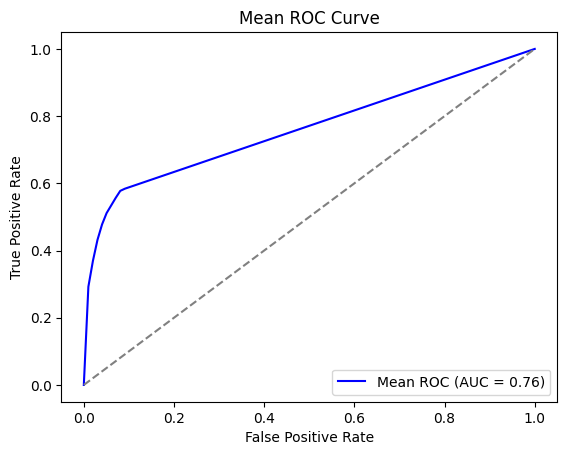

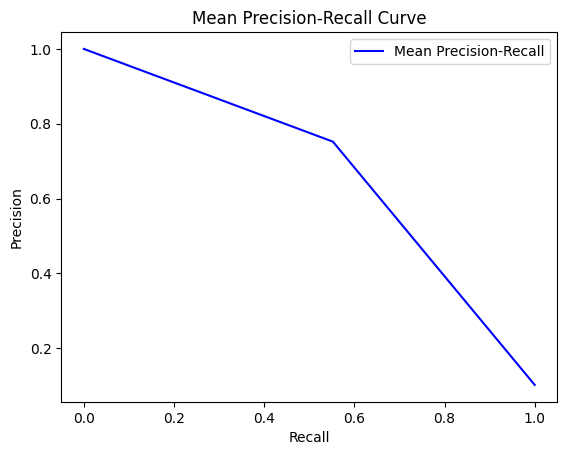

Average F1 Score: 0.6032
Average Matthews Correlation Coefficient (MCC): 0.5924
Class  1


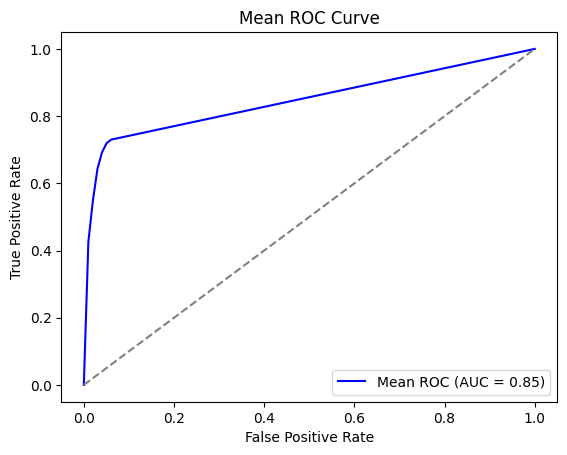

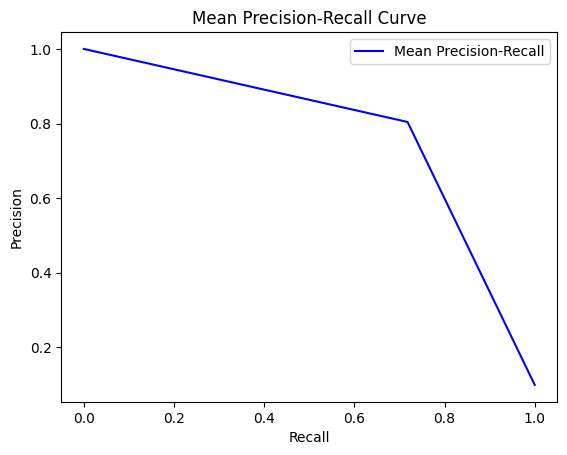

Average F1 Score: 0.7460
Average Matthews Correlation Coefficient (MCC): 0.7283
Class  2


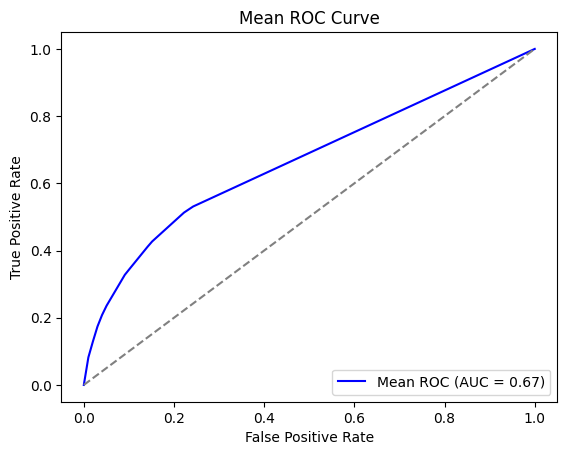

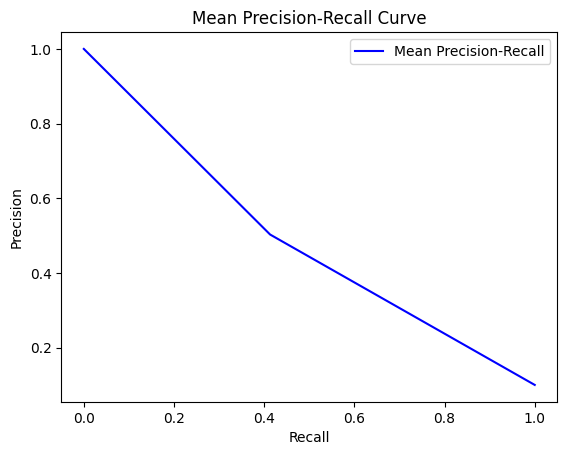

Average F1 Score: 0.3493
Average Matthews Correlation Coefficient (MCC): 0.3393
Class  3


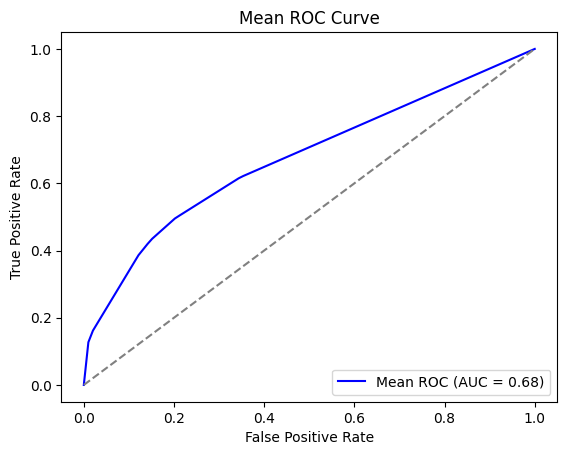

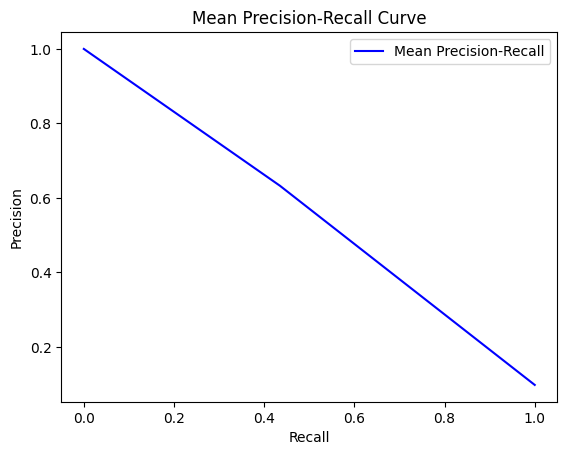

Average F1 Score: 0.3629
Average Matthews Correlation Coefficient (MCC): 0.3884
Class  4


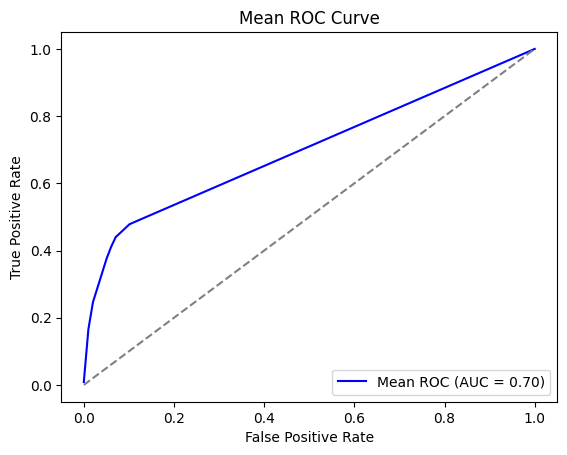

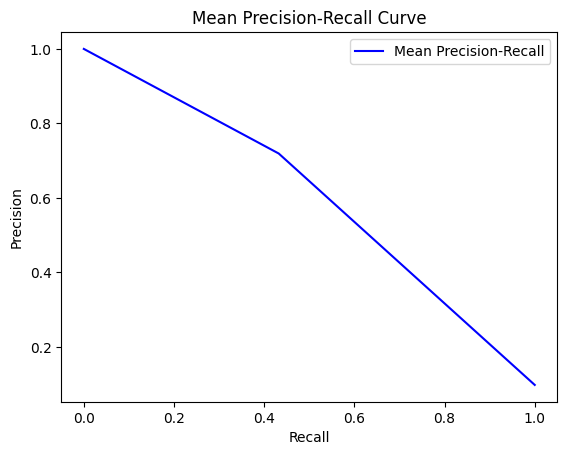

Average F1 Score: 0.4626
Average Matthews Correlation Coefficient (MCC): 0.4741
Class  5


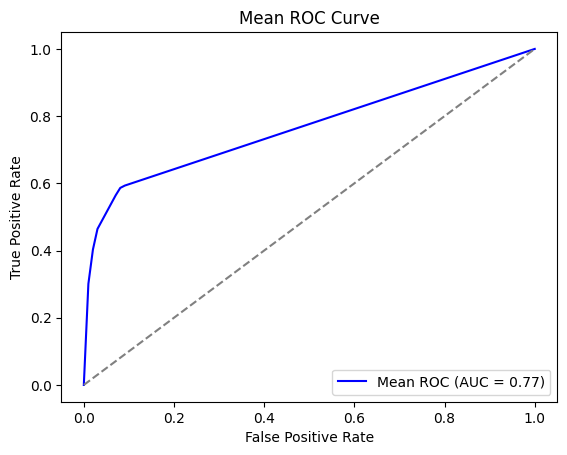

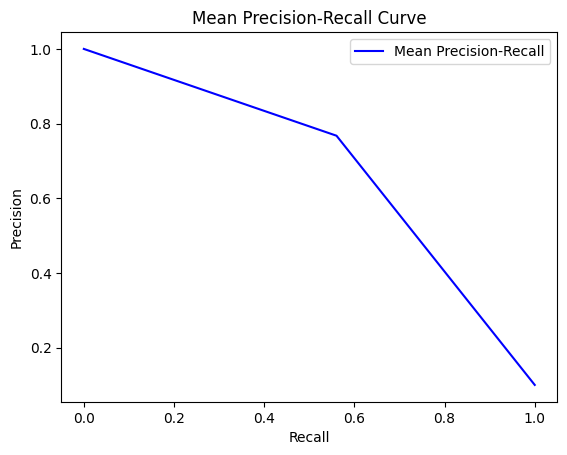

Average F1 Score: 0.6121
Average Matthews Correlation Coefficient (MCC): 0.6054
Class  6


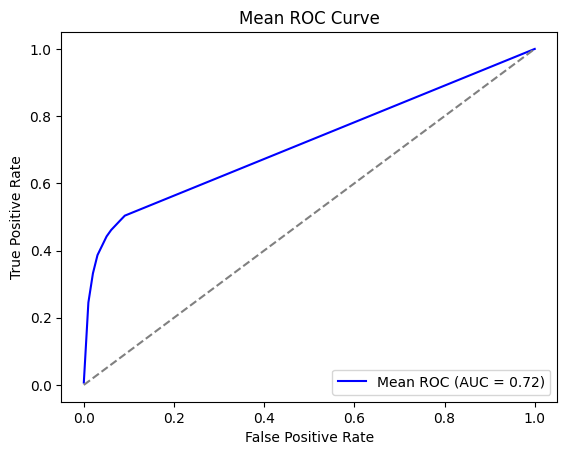

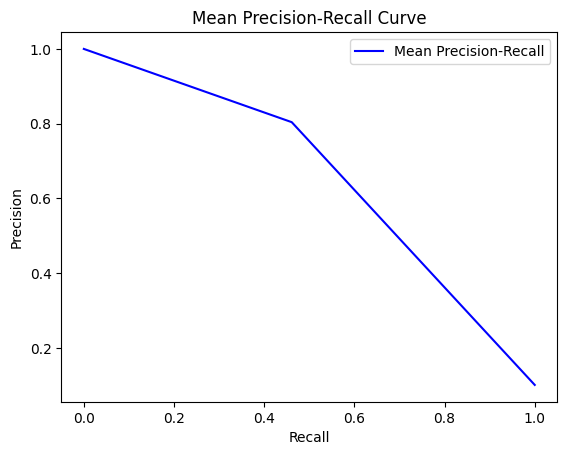

Average F1 Score: 0.5197
Average Matthews Correlation Coefficient (MCC): 0.5366
Class  7


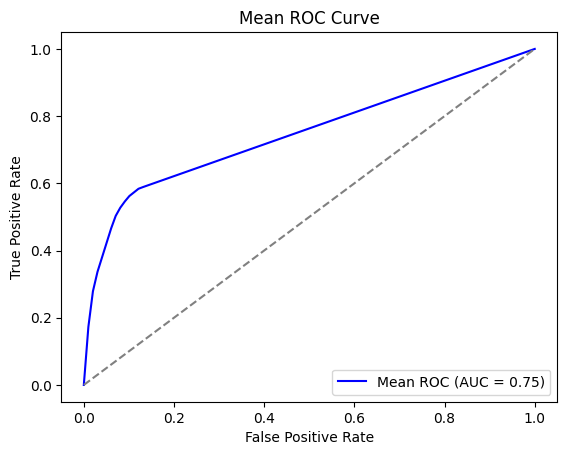

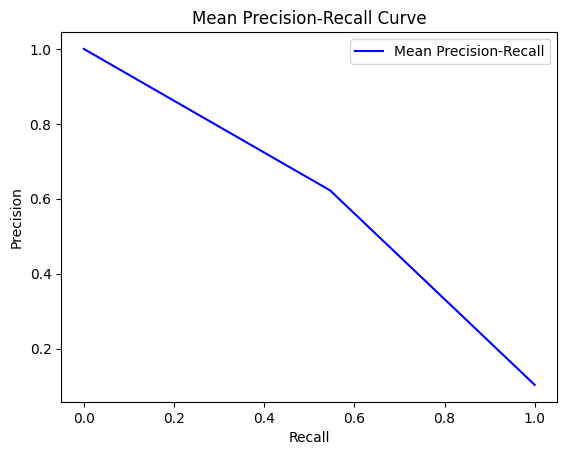

Average F1 Score: 0.5411
Average Matthews Correlation Coefficient (MCC): 0.5155
Class  8


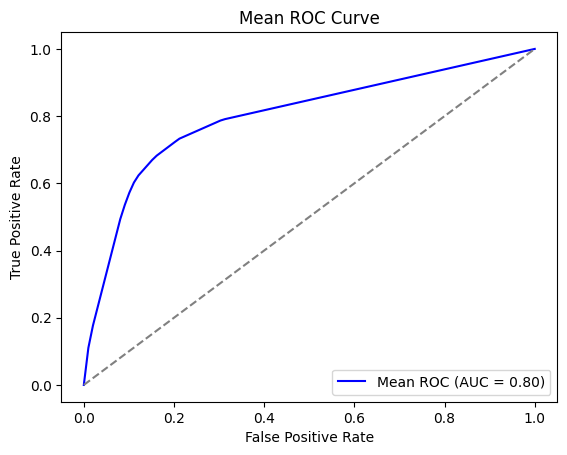

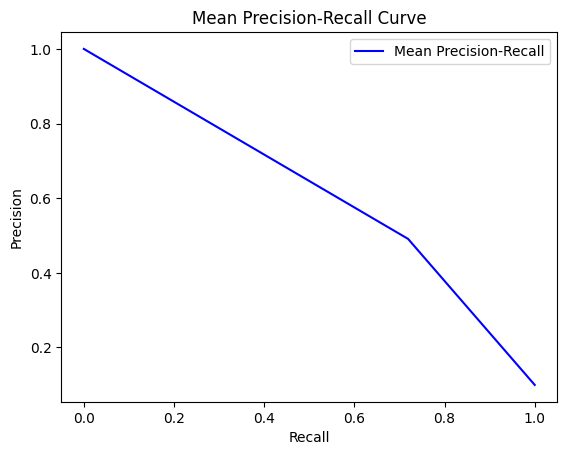

Average F1 Score: 0.5230
Average Matthews Correlation Coefficient (MCC): 0.5030
Class  9


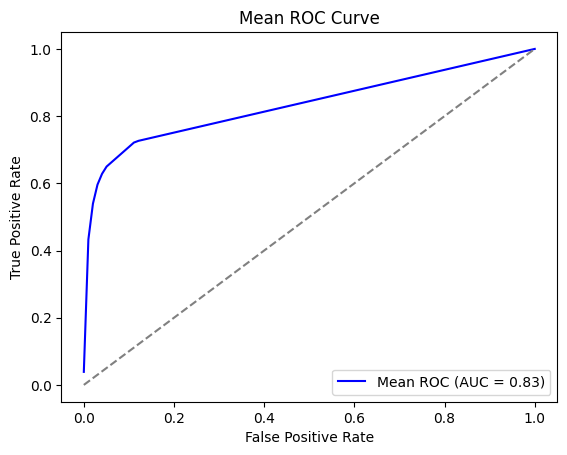

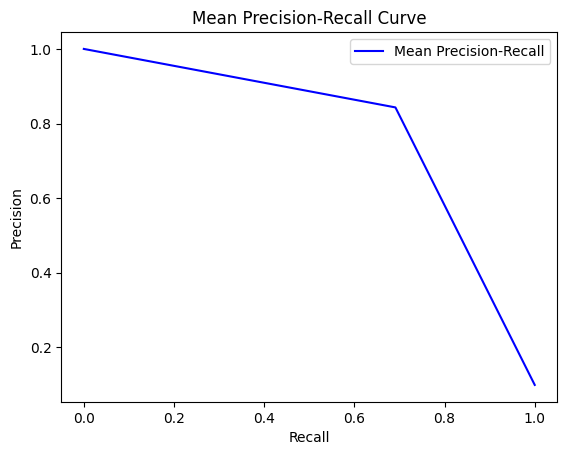

Average F1 Score: 0.7194
Average Matthews Correlation Coefficient (MCC): 0.7197


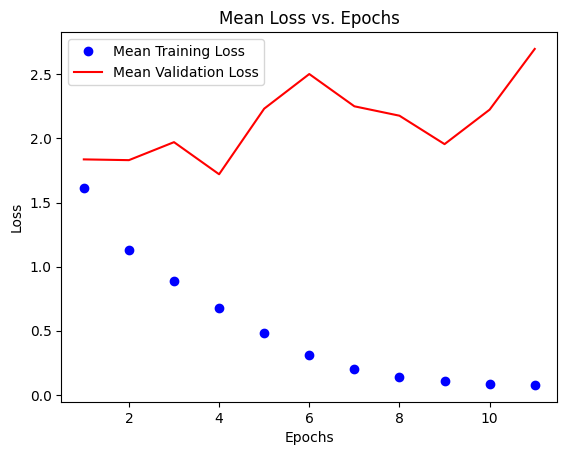

Average Validation Loss: 2.6365
Average AUC for all classes: 0.7516


In [15]:
# Print average validation accuracy over all folds
avg_val_acc = np.mean([h.history['val_accuracy'][-1] for h in all_histories])
print(f'Average Validation Accuracy: {avg_val_acc * 100:.2f}%')
# Plot AUC-ROC curve
mean_aucs=[]
for i in range(10):
    print('Class ',i)

    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_t_fpr[i], all_t_tpr[i])], axis=0)
    mean_aucs.append(np.mean(all_t_auc[i]))
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.2f})'.format(np.mean(all_t_auc[i])))
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Plot Precision-Recall curve
    mean_precision = np.mean(all_t_precisions[i], axis=0)
    mean_recall = np.mean(all_t_recalls[i], axis=0)
    plt.figure()
    plt.plot(mean_recall, mean_precision, color='b', label='Mean Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Mean Precision-Recall Curve')
    plt.legend(loc='upper right')
    plt.show()

    # Print average metrics over all folds
    avg_f1 = np.mean(all_t_f1_scores[i])
    print(f'Average F1 Score: {avg_f1:.4f}')
    avg_mcc = np.mean(all_t_mcc[i])
    print(f'Average Matthews Correlation Coefficient (MCC): {avg_mcc:.4f}')

# Plot Mean Loss vs. Epochs

min_length = min(len(h.history['loss']) for h in all_histories)

# Truncate or zero-pad all training histories to have the same length
all_train_losses = [np.array(h.history['loss'][:min_length]) for h in all_histories]
all_val_losses = [np.array(h.history['val_loss'][:min_length]) for h in all_histories]


mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
epochs = range(1, len(mean_train_loss) + 1)
plt.figure()
plt.plot(epochs, mean_train_loss, 'bo', label='Mean Training Loss')
plt.plot(epochs, mean_val_loss, 'r', label='Mean Validation Loss')
plt.title('Mean Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#avg_mcc = np.mean(all_t_mcc[i])
avg_loss = np.mean(all_losses)

#print(f'Average Matthews Correlation Coefficient (MCC): {avg_mcc:.4f}')
print(f'Average Validation Loss: {avg_loss:.4f}')

mean_aucs=np.mean(np.array(mean_aucs))
print(f'Average AUC for all classes: {mean_aucs:.4f}')

## Model 2 Data Processing

In [12]:
path="animals/animals"
data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      
print(data["labels"])
df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

['Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat'

In [13]:
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath    labels
0  animals/animals/Elephant/Elephant-Train (626)....  Elephant
1    animals/animals/Hippo/Hippo - Train (1313).jpeg     Hippo
2    animals/animals/Beetle/Beetle-Train (1453).jpeg    Beetle
3     animals/animals/Hippo/Hippo - Train (549).jpeg     Hippo
4            animals/animals/Panda/Panda (2791).jpeg     Panda
(14000, 3)
----------Test--------------
                                          imgpath  labels
0        animals/animals/Cow/Cow-Train (906).jpeg     Cow
1  animals/animals/Beetle/Beetle-Train (773).jpeg  Beetle
2   animals/animals/Mouse/Mouse-Train (1190).jpeg   Mouse
3  animals/animals/Beetle/Beetle-Train (707).jpeg  Beetle
4         animals/animals/Dog/Dog-Train (121).jpg     Dog
(6000, 3)


In [14]:
h=100
w=100
classes = len(df['labels'].unique())
BATCH_SIZE = 16
IMAGE_SIZE = (h, w)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Split the data into 2 categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


## Model 2

In [15]:
tuner= kt.GridSearch(ResNet,
                     objective='val_accuracy',
                     project_name='2ResNet_tuning')

In [16]:
def residual_block(x, filters, kernel_size=3, stride=1, use_bottleneck=False):
    shortcut = x
    
    if use_bottleneck:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet(hp):
    input_shape = (h, w, 3)  # Adjust input shape according to your needs
    num_classes = classes
    input_tensor = layers.Input(shape=input_shape)
    hp_kernel_size = hp.Choice('kernel_size',[5,6,7])
    hp_dropout = hp.Choice('dropout',[0.0,0.2,0.3,0.4])
    
    
    x = layers.Conv2D(64, kernel_size=hp_kernel_size, strides=2, padding='same', data_format='channels_last')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(hp_dropout)(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual blocks
    num_blocks_list = [3, 4, 6, 3] 
    filters_list = [64, 128, 256, 512]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        filters = filters_list[i]
        stride = 1 if i == 0 else 2

        for j in range(num_blocks):
            x = residual_block(x, filters, stride=stride if j == 0 else 1, use_bottleneck=(j == 0 and i > 0))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='resnet')
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
tuner.search(train_data_generator,validation_data=val_data_generator, epochs=1000,validation_split=0.2 , callbacks=[es])

Trial 12 Complete [00h 01m 30s]
val_accuracy: 0.5414285659790039

Best val_accuracy So Far: 0.6735714077949524
Total elapsed time: 00h 24m 01s


In [18]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'kernel_size': 5, 'dropout': 0.2}


In [19]:
batch_sizes = [32,64,128]
losses = []
accuracies = []
for b in batch_sizes:
    classes = len(df['labels'].unique())
    BATCH_SIZE = b
    IMAGE_SIZE = (h, w)

    generator = ImageDataGenerator(
        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    )

    # Split the data into 2 categories.
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )


    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{batch_sizes}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    losses.append(val_loss)
    accuracies.append(val_acc)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 14000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.
Epoch 1/200


2023-11-19 20:25:29.195788: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


438/438 [==============================] - 16s 25ms/step - loss: 1.5489 - accuracy: 0.4721 - val_loss: 2.2131 - val_accuracy: 0.4108
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 9s 21ms/step - loss: 1.0849 - accuracy: 0.6282 - val_loss: 1.6728 - val_accuracy: 0.4747
Epoch 3/200
438/438 [==============================] - 9s 21ms/step - loss: 0.8560 - accuracy: 0.7132 - val_loss: 1.5882 - val_accuracy: 0.5268
Epoch 4/200
438/438 [==============================] - 9s 21ms/step - loss: 0.6670 - accuracy: 0.7736 - val_loss: 1.6682 - val_accuracy: 0.5402
Epoch 5/200
438/438 [==============================] - 10s 22ms/step - loss: 0.4815 - accuracy: 0.8370 - val_loss: 1.4605 - val_accuracy: 0.5738
Epoch 6/200
438/438 [==============================] - 9s 21ms/step - loss: 0.3285 - accuracy: 0.8919 - val_loss: 2.1587 - val_accuracy: 0.5347
Epoch 7/200
438/438 [==============================] - 9s 21ms/step - loss: 0.2202 - accuracy: 0.9264 - val_loss: 1.5523 - val_accuracy: 0.6047
Epoch 8/200
438/438 [==============================] - 9s 21ms/step - loss: 0.1672 - accuracy: 0.9435 - val_loss: 1.5903 - val_accuracy: 0.6360
Epo

2023-11-19 20:27:45.314693: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


219/219 [==============================] - 13s 37ms/step - loss: 1.5613 - accuracy: 0.4660 - val_loss: 1.7217 - val_accuracy: 0.3893
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - 7s 32ms/step - loss: 1.0914 - accuracy: 0.6299 - val_loss: 2.3580 - val_accuracy: 0.3420
Epoch 3/200
219/219 [==============================] - 7s 32ms/step - loss: 0.8495 - accuracy: 0.7118 - val_loss: 1.4542 - val_accuracy: 0.5233
Epoch 4/200
219/219 [==============================] - 7s 31ms/step - loss: 0.6372 - accuracy: 0.7865 - val_loss: 1.4439 - val_accuracy: 0.5672
Epoch 5/200
219/219 [==============================] - 7s 33ms/step - loss: 0.4262 - accuracy: 0.8567 - val_loss: 2.9687 - val_accuracy: 0.3922
Epoch 6/200
219/219 [==============================] - 7s 33ms/step - loss: 0.2699 - accuracy: 0.9124 - val_loss: 2.8292 - val_accuracy: 0.4612
Epoch 7/200
219/219 [==============================] - 7s 33ms/step - loss: 0.1827 - accuracy: 0.9413 - val_loss: 2.3567 - val_accuracy: 0.5248
Epoch 8/200
219/219 [==============================] - 7s 32ms/step - loss: 0.1239 - accuracy: 0.9620 - val_loss: 2.0574 - val_accuracy: 0.5485
Epoc

2023-11-19 20:28:57.105683: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 13s 66ms/step - loss: 1.7350 - accuracy: 0.4187 - val_loss: 1.8451 - val_accuracy: 0.3342
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 7s 60ms/step - loss: 1.1654 - accuracy: 0.5990 - val_loss: 1.7791 - val_accuracy: 0.4078
Epoch 3/200
110/110 [==============================] - 7s 61ms/step - loss: 0.9204 - accuracy: 0.6871 - val_loss: 1.5376 - val_accuracy: 0.5127
Epoch 4/200
110/110 [==============================] - 7s 60ms/step - loss: 0.7157 - accuracy: 0.7591 - val_loss: 2.1516 - val_accuracy: 0.4260
Epoch 5/200
110/110 [==============================] - 7s 59ms/step - loss: 0.5124 - accuracy: 0.8291 - val_loss: 1.6643 - val_accuracy: 0.5408
Epoch 6/200
110/110 [==============================] - 7s 60ms/step - loss: 0.3406 - accuracy: 0.8897 - val_loss: 2.7983 - val_accuracy: 0.4483
Epoch 7/200
110/110 [==============================] - 7s 62ms/step - loss: 0.2379 - accuracy: 0.9223 - val_loss: 1.9672 - val_accuracy: 0.5452
Epoch 8/200
110/110 [==============================] - 7s 62ms/step - loss: 0.1438 - accuracy: 0.9564 - val_loss: 1.4182 - val_accuracy: 0.6637
Epoc

In [20]:
print(losses)
print(accuracies)

[1.832022786140442, 2.6801371574401855, 2.499871253967285]
[0.6161666512489319, 0.5328333377838135, 0.5651666522026062]


### Modificar esto en base a lo que salga arriba

In [23]:
h=100
w=100
BATCH_SIZE = 32
IMAGE_SIZE = (h, w)

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
all_histories = []
all_auc = []
all_precisions = []
all_recalls = []
all_f1_scores = []
all_mcc = []
all_losses = []
all_fpr = []  
all_tpr = []

# Iterate through the folds
for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(train_df['imgpath'], train_df['labels'])):
    print(f'Fold {fold + 1}')

    generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

    # Split data into training and validation sets
    train_fold_df, val_fold_df = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # Reset indices
    train_fold_df = train_fold_df.reset_index(drop=True)
    val_fold_df = val_fold_df.reset_index(drop=True)

    # Data generators
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=val_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{fold + 1}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

    # Store history
    all_histories.append(history)
    # Plot AUC-ROC
    val_predictions = resnet_model.predict(val_data_generator)
    val_predictions = resnet_model.predict(val_data_generator)

    val_classes_array = np.array(val_data_generator.classes)
    fprs = []
    tprs = []
    aucs = []

    indep_pred=[]

    
    for i in range(10):
        temp=[]
        for v in val_predictions:
            vs=np.argmax(v)
            if vs==i:
                temp.append(True)
            else:
                temp.append(False)
        indep_pred.append(temp)
        
    print(len(indep_pred))
        
    # Compute ROC curve and ROC area for each class
    for i in range(10):
        fpr, tpr, thresholds = roc_curve(val_classes_array==i, indep_pred[i])
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc(fpr, tpr))
    
    
    all_auc.append(aucs)
    all_fpr.append(fprs)
    all_tpr.append(tprs)

    precisions = []
    recalls = []

    # Plot Precision-Recall curve
    for i in range(10):
        precision, recall, _ = precision_recall_curve(val_classes_array==i, indep_pred[i])
        precisions.append(precision)
        recalls.append(recall)

    all_precisions.append(precisions)
    all_recalls.append(recalls)

    # Calculate and store F1 score, MCC, and loss
    f1_scores = []
    mccs = []


    for i in range(10):
        f1 = f1_score(val_classes_array==i, indep_pred[i])
        mcc = matthews_corrcoef(val_classes_array==i, indep_pred[i])
        f1_scores.append(f1)
        mccs.append(mcc)
    
    all_f1_scores.append(f1_scores)
    all_mcc.append(mccs)
    all_losses.append(val_loss)

Fold 1
Found 12600 validated image filenames belonging to 10 classes.
Found 1400 validated image filenames belonging to 10 classes.
Epoch 1/200
394/394 [==============================] - 13s 19ms/step - loss: 1.5682 - accuracy: 0.4635 - val_loss: 2.0277 - val_accuracy: 0.3986
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 6s 16ms/step - loss: 1.1227 - accuracy: 0.6172 - val_loss: 1.7050 - val_accuracy: 0.4786
Epoch 3/200
394/394 [==============================] - 7s 17ms/step - loss: 0.8803 - accuracy: 0.7051 - val_loss: 1.2106 - val_accuracy: 0.5943
Epoch 4/200
394/394 [==============================] - 7s 17ms/step - loss: 0.6643 - accuracy: 0.7752 - val_loss: 1.6625 - val_accuracy: 0.5179
Epoch 5/200
394/394 [==============================] - 7s 18ms/step - loss: 0.4843 - accuracy: 0.8372 - val_loss: 1.7606 - val_accuracy: 0.5364
Epoch 6/200
394/394 [==============================] - 6s 16ms/step - loss: 0.3190 - accuracy: 0.8951 - val_loss: 1.6284 - val_accuracy: 0.5600
Epoch 7/200
394/394 [==============================] - 6s 16ms/step - loss: 0.2295 - accuracy: 0.9225 - val_loss: 1.5541 - val_accuracy: 0.6479
Epoch 8/200
394/394 [==============================] - 7s 18ms/step - loss: 0.1662 - accuracy: 0.9464 - val_loss: 1.8128 - val_accuracy: 0.5757
Epoc

2023-11-19 20:36:30.160845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


394/394 [==============================] - 12s 18ms/step - loss: 1.5597 - accuracy: 0.4669 - val_loss: 1.6119 - val_accuracy: 0.4529
Epoch 2/200
  1/394 [..............................] - ETA: 16s - loss: 1.3576 - accuracy: 0.5000

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 7s 18ms/step - loss: 1.1250 - accuracy: 0.6190 - val_loss: 1.9141 - val_accuracy: 0.3929
Epoch 3/200
394/394 [==============================] - 6s 15ms/step - loss: 0.8764 - accuracy: 0.7071 - val_loss: 2.8417 - val_accuracy: 0.3043
Epoch 4/200
394/394 [==============================] - 6s 16ms/step - loss: 0.6836 - accuracy: 0.7676 - val_loss: 1.8233 - val_accuracy: 0.4871
Epoch 5/200
394/394 [==============================] - 6s 16ms/step - loss: 0.4930 - accuracy: 0.8346 - val_loss: 2.0269 - val_accuracy: 0.5114
Epoch 6/200
394/394 [==============================] - 7s 17ms/step - loss: 0.3292 - accuracy: 0.8888 - val_loss: 2.4752 - val_accuracy: 0.4421
Epoch 7/200
394/394 [==============================] - 6s 16ms/step - loss: 0.2283 - accuracy: 0.9224 - val_loss: 2.8539 - val_accuracy: 0.4893
Epoch 8/200
394/394 [==============================] - 7s 17ms/step - loss: 0.1650 - accuracy: 0.9457 - val_loss: 1.9569 - val_accuracy: 0.5657
Epoc

2023-11-19 20:38:02.914793: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


394/394 [==============================] - 12s 18ms/step - loss: 1.5775 - accuracy: 0.4637 - val_loss: 1.7679 - val_accuracy: 0.4179
Epoch 2/200
  1/394 [..............................] - ETA: 13s - loss: 1.3797 - accuracy: 0.4688

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 7s 18ms/step - loss: 1.1212 - accuracy: 0.6189 - val_loss: 1.5890 - val_accuracy: 0.4636
Epoch 3/200
394/394 [==============================] - 6s 16ms/step - loss: 0.8868 - accuracy: 0.7007 - val_loss: 1.9398 - val_accuracy: 0.4679
Epoch 4/200
394/394 [==============================] - 7s 19ms/step - loss: 0.6859 - accuracy: 0.7725 - val_loss: 1.4412 - val_accuracy: 0.5679
Epoch 5/200
394/394 [==============================] - 7s 17ms/step - loss: 0.5018 - accuracy: 0.8329 - val_loss: 1.7155 - val_accuracy: 0.5514
Epoch 6/200
394/394 [==============================] - 7s 17ms/step - loss: 0.3277 - accuracy: 0.8883 - val_loss: 1.9466 - val_accuracy: 0.5279
Epoch 7/200
394/394 [==============================] - 7s 17ms/step - loss: 0.2280 - accuracy: 0.9277 - val_loss: 1.3298 - val_accuracy: 0.6514
Epoch 8/200
394/394 [==============================] - 7s 17ms/step - loss: 0.1690 - accuracy: 0.9460 - val_loss: 1.6700 - val_accuracy: 0.6293
Epoc

2023-11-19 20:39:32.338746: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


394/394 [==============================] - 14s 19ms/step - loss: 1.5542 - accuracy: 0.4686 - val_loss: 1.5314 - val_accuracy: 0.4643
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 7s 18ms/step - loss: 1.1148 - accuracy: 0.6231 - val_loss: 1.4052 - val_accuracy: 0.5607
Epoch 3/200
394/394 [==============================] - 6s 16ms/step - loss: 0.8745 - accuracy: 0.7072 - val_loss: 1.8698 - val_accuracy: 0.4993
Epoch 4/200
394/394 [==============================] - 6s 16ms/step - loss: 0.6678 - accuracy: 0.7787 - val_loss: 2.3840 - val_accuracy: 0.4164
Epoch 5/200
394/394 [==============================] - 7s 19ms/step - loss: 0.4727 - accuracy: 0.8393 - val_loss: 1.3151 - val_accuracy: 0.6271
Epoch 6/200
394/394 [==============================] - 6s 16ms/step - loss: 0.3288 - accuracy: 0.8896 - val_loss: 3.0653 - val_accuracy: 0.4650
Epoch 7/200
394/394 [==============================] - 7s 18ms/step - loss: 0.2151 - accuracy: 0.9302 - val_loss: 2.7130 - val_accuracy: 0.5093
Epoch 8/200
394/394 [==============================] - 7s 17ms/step - loss: 0.1779 - accuracy: 0.9375 - val_loss: 2.3480 - val_accuracy: 0.5500
Epoc

2023-11-19 20:40:47.880053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_11/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


394/394 [==============================] - 12s 19ms/step - loss: 1.5687 - accuracy: 0.4714 - val_loss: 1.4829 - val_accuracy: 0.5014
Epoch 2/200
  1/394 [..............................] - ETA: 13s - loss: 1.3904 - accuracy: 0.5000

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 6s 16ms/step - loss: 1.0960 - accuracy: 0.6247 - val_loss: 1.5736 - val_accuracy: 0.4857
Epoch 3/200
394/394 [==============================] - 7s 18ms/step - loss: 0.8726 - accuracy: 0.7045 - val_loss: 1.7939 - val_accuracy: 0.4714
Epoch 4/200
394/394 [==============================] - 6s 16ms/step - loss: 0.6633 - accuracy: 0.7760 - val_loss: 1.3484 - val_accuracy: 0.6100
Epoch 5/200
394/394 [==============================] - 7s 17ms/step - loss: 0.4885 - accuracy: 0.8342 - val_loss: 1.2630 - val_accuracy: 0.6514
Epoch 6/200
394/394 [==============================] - 7s 18ms/step - loss: 0.3356 - accuracy: 0.8856 - val_loss: 2.8705 - val_accuracy: 0.4593
Epoch 7/200
394/394 [==============================] - 7s 17ms/step - loss: 0.2232 - accuracy: 0.9230 - val_loss: 2.7123 - val_accuracy: 0.4700
Epoch 8/200
394/394 [==============================] - 7s 18ms/step - loss: 0.1605 - accuracy: 0.9487 - val_loss: 2.6935 - val_accuracy: 0.4943
Epoc

2023-11-19 20:42:02.881159: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


392/394 [============================>.] - ETA: 0s - loss: 1.5459 - accuracy: 0.4695

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 13s 20ms/step - loss: 1.5451 - accuracy: 0.4697 - val_loss: 1.4666 - val_accuracy: 0.4964
Epoch 2/200
394/394 [==============================] - 7s 18ms/step - loss: 1.1144 - accuracy: 0.6207 - val_loss: 1.6767 - val_accuracy: 0.4464
Epoch 3/200
394/394 [==============================] - 6s 16ms/step - loss: 0.8857 - accuracy: 0.6986 - val_loss: 1.4356 - val_accuracy: 0.5450
Epoch 4/200
394/394 [==============================] - 7s 17ms/step - loss: 0.7057 - accuracy: 0.7628 - val_loss: 1.6266 - val_accuracy: 0.4979
Epoch 5/200
394/394 [==============================] - 7s 18ms/step - loss: 0.5099 - accuracy: 0.8297 - val_loss: 2.0834 - val_accuracy: 0.4407
Epoch 6/200
394/394 [==============================] - 7s 18ms/step - loss: 0.3476 - accuracy: 0.8836 - val_loss: 1.8118 - val_accuracy: 0.5836
Epoch 7/200
394/394 [==============================] - 7s 17ms/step - loss: 0.2445 - accuracy: 0.9176 - val_loss: 1.8421 - val_accuracy: 0.5929
Epo

2023-11-19 20:44:34.924414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_13/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


394/394 [==============================] - 12s 19ms/step - loss: 1.5572 - accuracy: 0.4663 - val_loss: 1.5422 - val_accuracy: 0.4629
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 7s 18ms/step - loss: 1.1144 - accuracy: 0.6202 - val_loss: 1.2647 - val_accuracy: 0.5843
Epoch 3/200
394/394 [==============================] - 7s 18ms/step - loss: 0.8596 - accuracy: 0.7109 - val_loss: 1.5837 - val_accuracy: 0.5321
Epoch 4/200
394/394 [==============================] - 7s 17ms/step - loss: 0.6602 - accuracy: 0.7822 - val_loss: 1.6978 - val_accuracy: 0.5171
Epoch 5/200
394/394 [==============================] - 7s 17ms/step - loss: 0.4711 - accuracy: 0.8428 - val_loss: 2.1144 - val_accuracy: 0.5064
Epoch 6/200
394/394 [==============================] - 7s 17ms/step - loss: 0.3115 - accuracy: 0.8960 - val_loss: 2.5845 - val_accuracy: 0.4221
Epoch 7/200
394/394 [==============================] - 6s 16ms/step - loss: 0.2065 - accuracy: 0.9302 - val_loss: 2.1289 - val_accuracy: 0.5671
Epoch 7: early stopping
44/44 [==============================] - 0s 11ms/step - loss: 2.1289 - accuracy: 0.5671
Validation Accuracy: 56.71%
44/44 [=

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 7s 18ms/step - loss: 1.1193 - accuracy: 0.6198 - val_loss: 2.5598 - val_accuracy: 0.3514
Epoch 3/200
394/394 [==============================] - 7s 18ms/step - loss: 0.8807 - accuracy: 0.6995 - val_loss: 2.1213 - val_accuracy: 0.4514
Epoch 4/200
394/394 [==============================] - 6s 16ms/step - loss: 0.6852 - accuracy: 0.7689 - val_loss: 2.1129 - val_accuracy: 0.4000
Epoch 5/200
394/394 [==============================] - 7s 18ms/step - loss: 0.4883 - accuracy: 0.8361 - val_loss: 2.0264 - val_accuracy: 0.4200
Epoch 6/200
394/394 [==============================] - 8s 19ms/step - loss: 0.3381 - accuracy: 0.8871 - val_loss: 1.6041 - val_accuracy: 0.5386
Epoch 7/200
394/394 [==============================] - 7s 17ms/step - loss: 0.2396 - accuracy: 0.9198 - val_loss: 2.1093 - val_accuracy: 0.5514
Epoch 8/200
394/394 [==============================] - 7s 18ms/step - loss: 0.1555 - accuracy: 0.9501 - val_loss: 1.6507 - val_accuracy: 0.6407
Epoc

2023-11-19 20:47:06.736221: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


394/394 [==============================] - 12s 17ms/step - loss: 1.5480 - accuracy: 0.4656 - val_loss: 1.8225 - val_accuracy: 0.4464
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 7s 18ms/step - loss: 1.1052 - accuracy: 0.6287 - val_loss: 1.6843 - val_accuracy: 0.4721
Epoch 3/200
394/394 [==============================] - 6s 16ms/step - loss: 0.8619 - accuracy: 0.7048 - val_loss: 1.7533 - val_accuracy: 0.4793
Epoch 4/200
394/394 [==============================] - 7s 19ms/step - loss: 0.6720 - accuracy: 0.7713 - val_loss: 1.7665 - val_accuracy: 0.5057
Epoch 5/200
394/394 [==============================] - 7s 17ms/step - loss: 0.4870 - accuracy: 0.8337 - val_loss: 1.4131 - val_accuracy: 0.5950
Epoch 6/200
394/394 [==============================] - 6s 16ms/step - loss: 0.3243 - accuracy: 0.8913 - val_loss: 1.8579 - val_accuracy: 0.5536
Epoch 7/200
394/394 [==============================] - 6s 16ms/step - loss: 0.2294 - accuracy: 0.9239 - val_loss: 1.7223 - val_accuracy: 0.6057
Epoch 8/200
394/394 [==============================] - 7s 18ms/step - loss: 0.1557 - accuracy: 0.9502 - val_loss: 2.3503 - val_accuracy: 0.5314
Epoc

2023-11-19 20:48:35.054478: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


394/394 [==============================] - 12s 19ms/step - loss: 1.5762 - accuracy: 0.4633 - val_loss: 1.9269 - val_accuracy: 0.3900


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
394/394 [==============================] - 7s 19ms/step - loss: 1.0929 - accuracy: 0.6305 - val_loss: 1.6219 - val_accuracy: 0.4700
Epoch 3/200
394/394 [==============================] - 6s 16ms/step - loss: 0.8661 - accuracy: 0.7105 - val_loss: 1.8162 - val_accuracy: 0.4850
Epoch 4/200
394/394 [==============================] - 7s 18ms/step - loss: 0.6769 - accuracy: 0.7768 - val_loss: 1.8579 - val_accuracy: 0.4964
Epoch 5/200
394/394 [==============================] - 7s 17ms/step - loss: 0.5099 - accuracy: 0.8306 - val_loss: 1.9922 - val_accuracy: 0.4957
Epoch 6/200
394/394 [==============================] - 7s 17ms/step - loss: 0.3462 - accuracy: 0.8858 - val_loss: 2.0880 - val_accuracy: 0.5357
Epoch 7/200
394/394 [==============================] - 7s 17ms/step - loss: 0.2371 - accuracy: 0.9227 - val_loss: 2.3695 - val_accuracy: 0.5386
Epoch 8/200
394/394 [==============================] - 6s 16ms/step - loss: 0.1735 - accuracy: 0.9410 - val_loss: 2.7082 - val_accuracy:

In [26]:
print(all_auc)

[[0.7108141695962741, 0.8233730224385123, 0.7773809523809523, 0.5183823529411765, 0.7478525000574199, 0.8720334161413708, 0.6447076737051882, 0.7850760792639774, 0.8286132394639403, 0.8297457196811939], [0.6760003582704494, 0.723845288132479, 0.8047619047619048, 0.6172708936548942, 0.6079606789315327, 0.8560858274325566, 0.8640531583779304, 0.8001150035385703, 0.6479355769943919, 0.8605623035275191], [0.778454510848877, 0.8961370158433126, 0.7303869830384702, 0.6874924146540216, 0.6715358643974367, 0.7478298097668419, 0.632766070110805, 0.8046930290162775, 0.8293650793650794, 0.7050359712230216], [0.7197877247587272, 0.8826556518464846, 0.7645182822813913, 0.8121752749507314, 0.6520970230767897, 0.7686507936507936, 0.8186871627219598, 0.6645830471218575, 0.5535714285714286, 0.790970395769031], [0.79234607874226, 0.739846188077294, 0.6291284181219656, 0.7720697447278234, 0.7674145095387532, 0.6496031746031746, 0.7658478694104212, 0.6604078202406228, 0.6928571428571428, 0.607913669064748

In [33]:
all_t_auc=[]
for i in range(10):
    t_auc=[]
    for j in range(10):
        t_auc.append(all_auc[j][i])
    all_t_auc.append(t_auc)

all_t_precisions=[]
for i in range(10):
    t_precisions=[]
    for j in range(10):
        t_precisions.append(all_precisions[j][i])
    all_t_precisions.append(t_precisions)

all_t_recalls=[]
for i in range(10):
    t_recalls=[]
    for j in range(10):
        t_recalls.append(all_recalls[j][i])
    all_t_recalls.append(t_recalls)

all_t_f1_scores=[]
for i in range(10):
    t_f1_scores=[]
    for j in range(10):
        t_f1_scores.append(all_f1_scores[j][i])
    all_t_f1_scores.append(t_f1_scores)

all_t_mcc=[]
for i in range(10):
    t_mcc=[]
    for j in range(10):
        t_mcc.append(all_mcc[j][i])
    all_t_mcc.append(t_mcc)


all_t_fpr=[]
for i in range(10):
    t_fpr=[]
    for j in range(10):
        t_fpr.append(all_fpr[j][i])
    all_t_fpr.append(t_fpr)

all_t_tpr=[]
for i in range(10):
    t_tpr=[]
    for j in range(10):
        t_tpr.append(all_tpr[j][i])
    all_t_tpr.append(t_tpr)




Average Validation Accuracy: 56.24%
Class  0


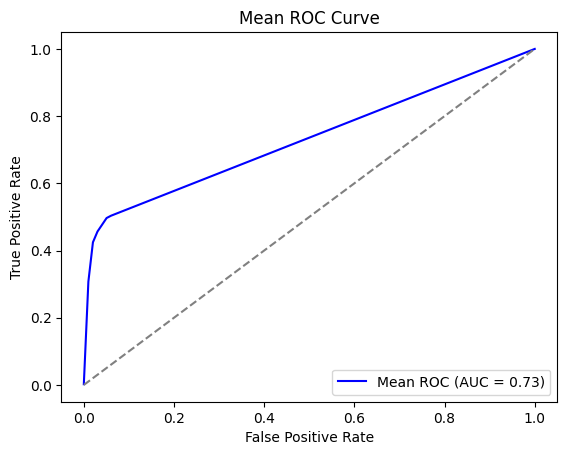

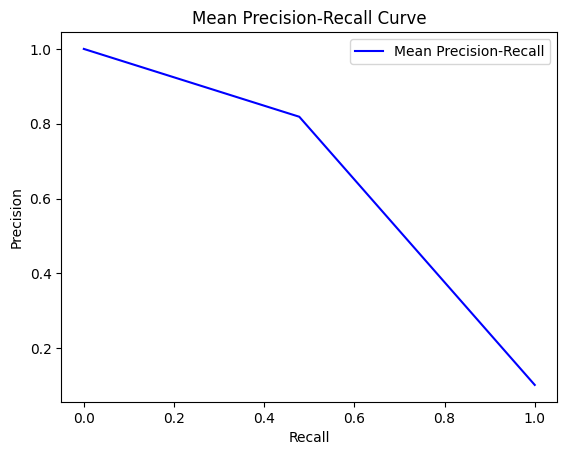

Average F1 Score: 0.5600
Class  1


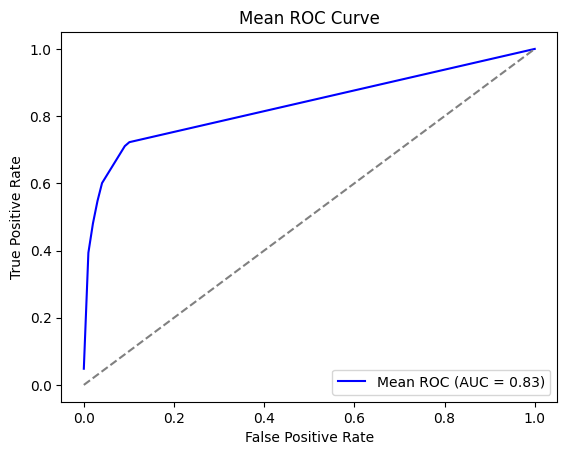

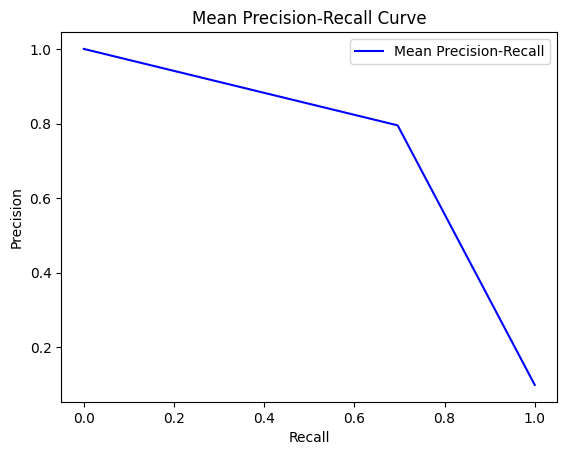

Average F1 Score: 0.7046
Class  2


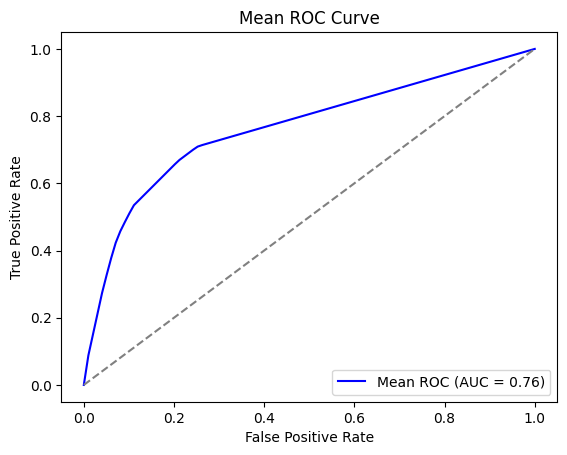

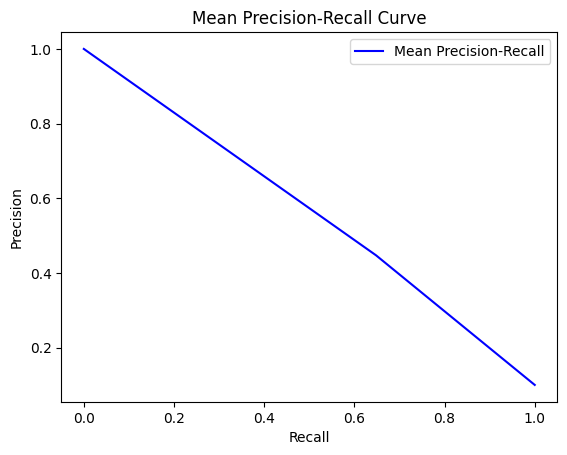

Average F1 Score: 0.4844
Class  3


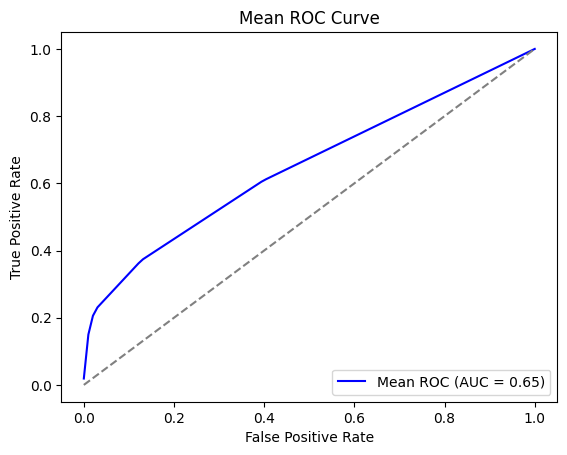

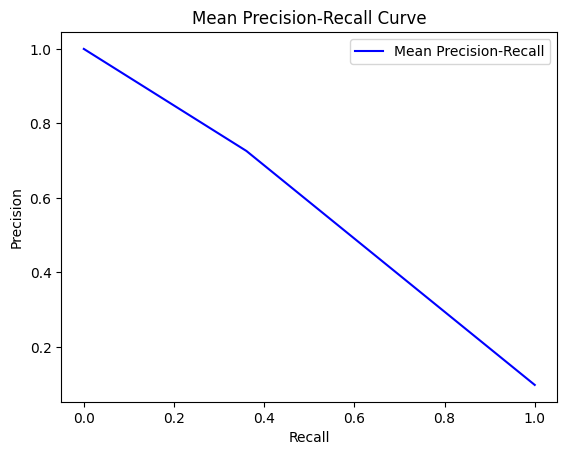

Average F1 Score: 0.3518
Class  4


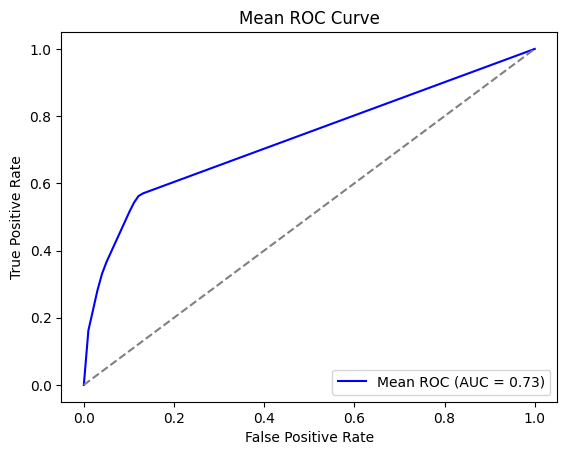

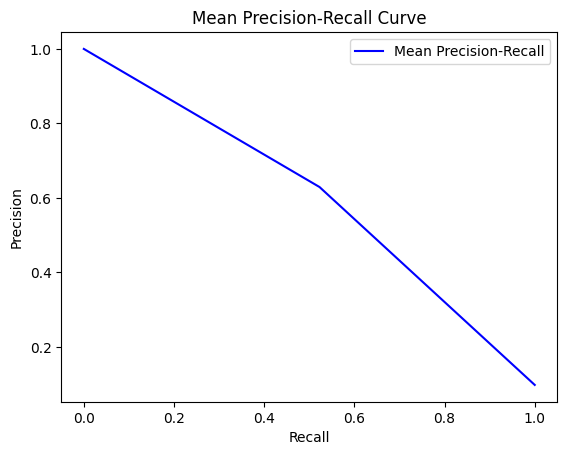

Average F1 Score: 0.4901
Class  5


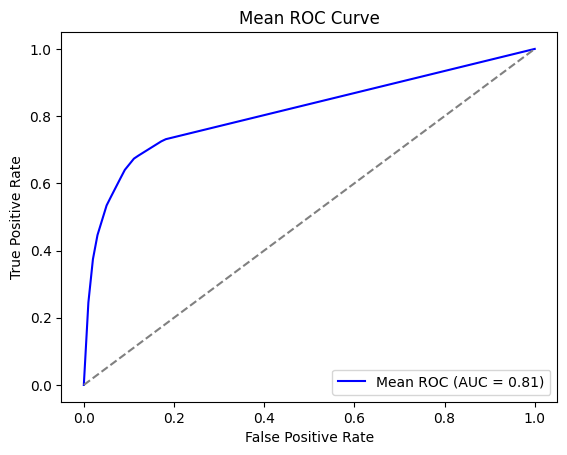

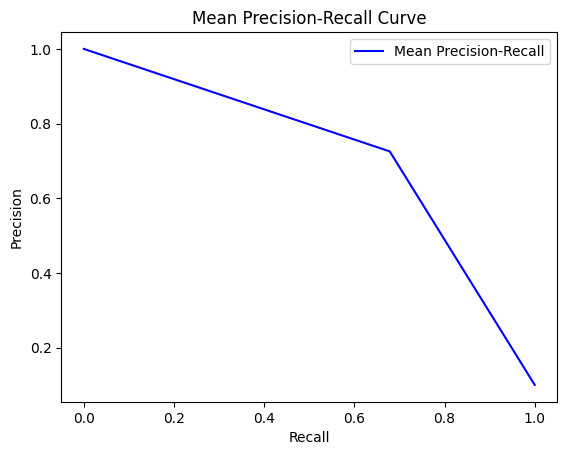

Average F1 Score: 0.6344
Class  6


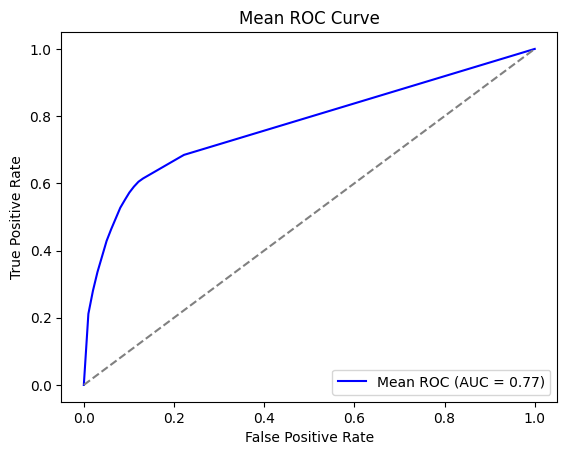

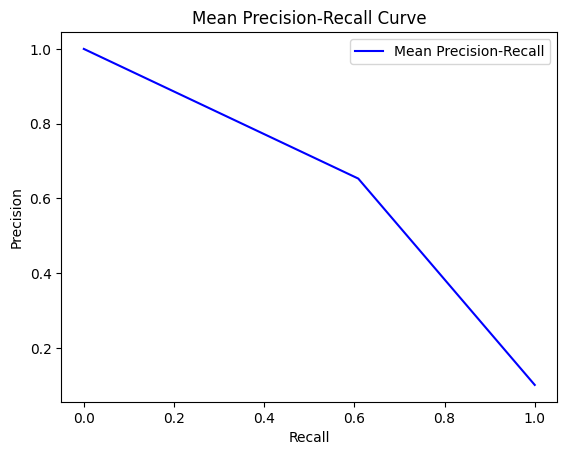

Average F1 Score: 0.5565
Class  7


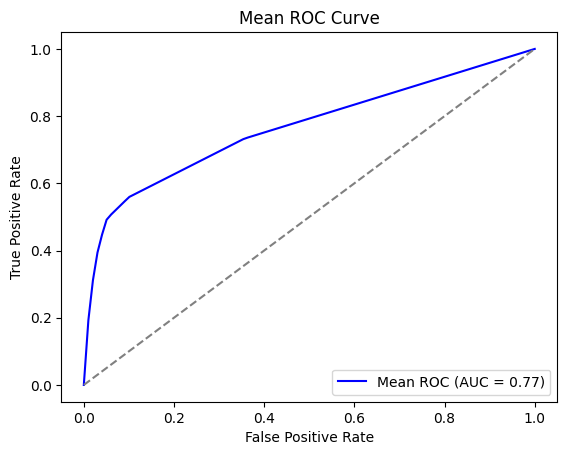

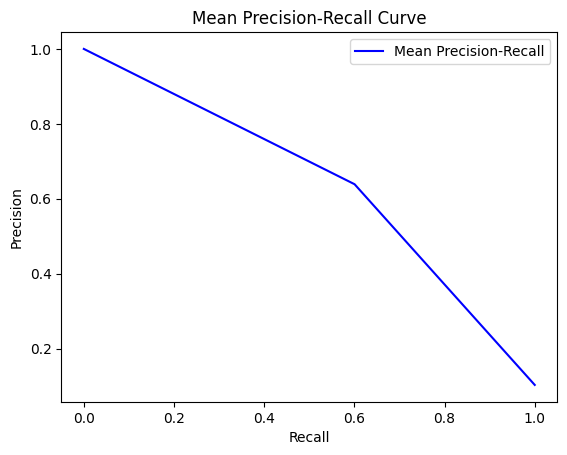

Average F1 Score: 0.5691
Class  8


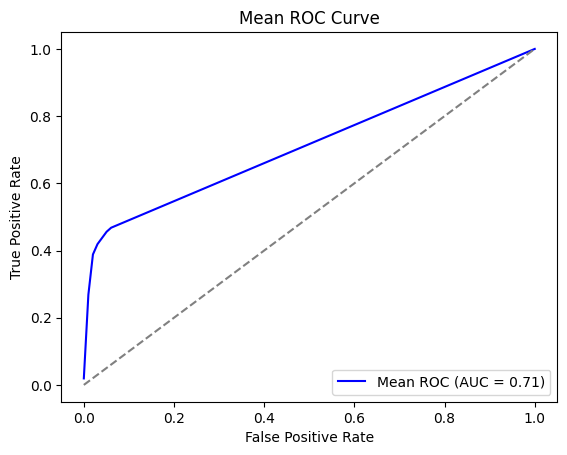

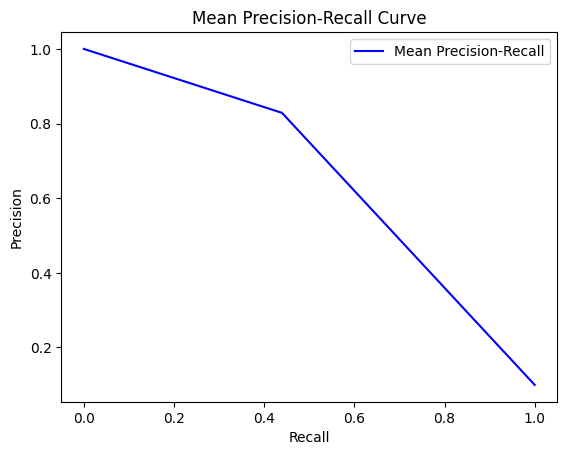

Average F1 Score: 0.5183
Class  9


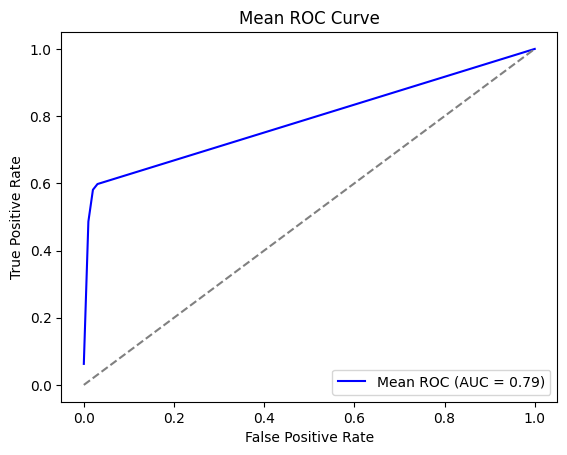

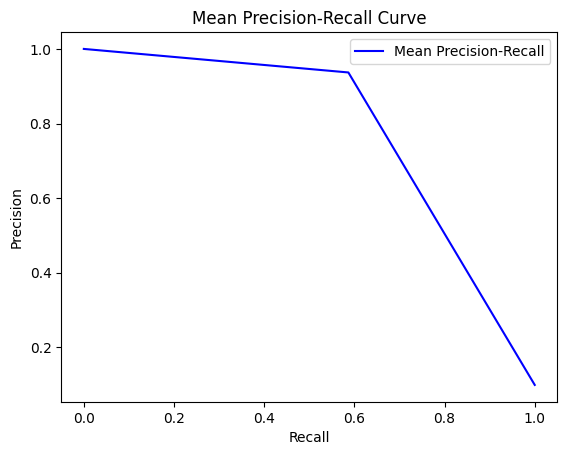

Average F1 Score: 0.6957


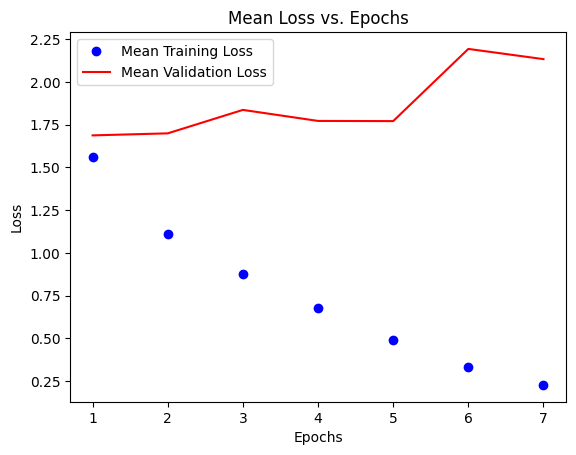

Average Validation Loss: 2.3614


In [41]:
# Print average validation accuracy over all folds
avg_val_acc = np.mean([h.history['val_accuracy'][-1] for h in all_histories])
print(f'Average Validation Accuracy: {avg_val_acc * 100:.2f}%')
# Plot AUC-ROC curve
mean_aucs=[]
for i in range(10):
    print('Class ',i)

    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_t_fpr[i], all_t_tpr[i])], axis=0)
    mean_aucs.append(np.mean(all_t_auc[i]))
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.2f})'.format(np.mean(all_t_auc[i])))
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Plot Precision-Recall curve
    mean_precision = np.mean(all_t_precisions[i], axis=0)
    mean_recall = np.mean(all_t_recalls[i], axis=0)
    plt.figure()
    plt.plot(mean_recall, mean_precision, color='b', label='Mean Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Mean Precision-Recall Curve')
    plt.legend(loc='upper right')
    plt.show()

    # Print average metrics over all folds
    avg_f1 = np.mean(all_t_f1_scores[i])
    print(f'Average F1 Score: {avg_f1:.4f}')
    avg_mcc = np.mean(all_t_mcc[i])
    print(f'Average Matthews Correlation Coefficient (MCC): {avg_mcc:.4f}')

# Plot Mean Loss vs. Epochs

min_length = min(len(h.history['loss']) for h in all_histories)

# Truncate or zero-pad all training histories to have the same length
all_train_losses = [np.array(h.history['loss'][:min_length]) for h in all_histories]
all_val_losses = [np.array(h.history['val_loss'][:min_length]) for h in all_histories]


mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
epochs = range(1, len(mean_train_loss) + 1)
plt.figure()
plt.plot(epochs, mean_train_loss, 'bo', label='Mean Training Loss')
plt.plot(epochs, mean_val_loss, 'r', label='Mean Validation Loss')
plt.title('Mean Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#avg_mcc = np.mean(all_t_mcc[i])
avg_loss = np.mean(all_losses)

#print(f'Average Matthews Correlation Coefficient (MCC): {avg_mcc:.4f}')
print(f'Average Validation Loss: {avg_loss:.4f}')

mean_aucs=np.mean(np.array(mean_aucs))
print(f'Average AUC for all classes: {mean_aucs:.4f}')